In [1]:
import torch
from torch import nn
import torch.distributions as D

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import datasets

In [2]:
device = torch.device("cuda:3")

### Define Flow

In [3]:
def craft_gmm():
    means = torch.tensor([
        [3.0, 3.0],
        [-3.0, -3.0],
        [3.0, -3.0],
        [-3.0, 3.0]
    ], device=device)

    covariances = torch.stack([
        torch.tensor([[2.0, 1.0],
                    [1.0, 2.0]], device=device),
        torch.tensor([[2.0, 1.0],
                    [1.0, 2.0]], device=device),
        torch.tensor([[2.0, -1.0],
                    [-1.0, 2.0]], device=device),
         torch.tensor([[2.0, -1.0],
                    [-1.0, 2.0]], device=device),
    ], dim=0)

    mix = D.Categorical(probs=torch.tensor([0.25, 0.25, 0.25, 0.25], device=device))
    comp = D.MultivariateNormal(loc=means, covariance_matrix=covariances)
    return D.MixtureSameFamily(mix, comp)

In [4]:
gmm = craft_gmm()

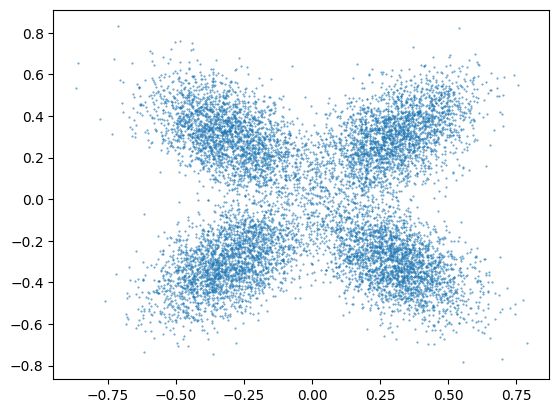

In [5]:
gmm_samples = gmm.sample((10000, )).clamp(min=-10.0, max=10.0).cpu()
gmm_samples /= 10.0
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=0.2,
            alpha=0.8)
plt.show()

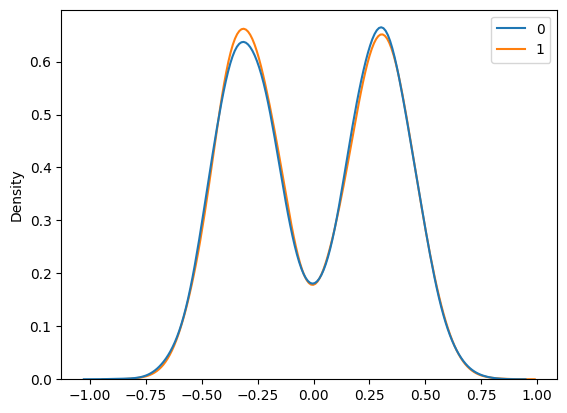

In [6]:
sns.kdeplot(gmm_samples)
plt.show()

In [7]:
class RealNVP(nn.Module):
    def __init__(self, masks):
        super().__init__()
        
        self.register_buffer("mask", masks)
        self.register_buffer("dummy_param", torch.zeros(0))
        nets = lambda: nn.Sequential(
                nn.Linear(2, 256), 
                nn.ReLU(), 
                nn.Linear(256, 256), 
                nn.ReLU(), 
                nn.Linear(256, 2), 
                nn.Tanh()
            )
        nett = lambda: nn.Sequential(
                nn.Linear(2, 256), 
                nn.ReLU(), 
                nn.Linear(256, 256), 
                nn.ReLU(), 
                nn.Linear(256, 2)
            )
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    @property
    def device(self):
        return self.dummy_param.device

    @property
    def prior(self):
        return D.MultivariateNormal(torch.zeros(2, device=self.device), 
                                    covariance_matrix=torch.eye(2, device=self.device))
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x * self.mask[i]
            s = self.s[i](x_) * (1 - self.mask[i])
            t = self.t[i](x_) * (1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1 - self.mask[i])
            t = self.t[i](z_) * (1 - self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self, x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batch_size): 
        z = self.prior.sample((batch_size, ))
        x = self.g(z)
        return x

### Test X

In [ ]:
num_flows = 4
steps = 10_000
batch_size = 64

masks = torch.tensor([[0, 1], [1, 0]] * num_flows).float()
model = RealNVP(masks).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

In [ ]:
model.train()
training_losses = []
for s in range(steps):
    gmm_samples = gmm.sample((batch_size, )).clamp(min=-10.0, max=10.0)
    gmm_samples /= 10.0

    optimizer.zero_grad()
    # Compute negative log-likelihood (NLL)
    log_prob = model.log_prob(gmm_samples)
    loss = -log_prob.mean()  # Maximize log-likelihood (equivalent to minimizing -log_prob)
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    if (s + 1) % 1000 == 0:
        print(f"[step {s + 1}/{steps}] loss: {loss.item():.3e}")

In [ ]:
plt.plot(training_losses, linewidth=0.1)
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [ ]:
model.eval()
with torch.inference_mode():
    x_samples = model.sample(10_000).cpu()

plt.scatter(x_samples[:, 0], 
            x_samples[:, 1],
            s=0.2,
            alpha=0.8)
plt.show()

In [ ]:
sns.kdeplot(x_samples)
plt.show()

### Test Moons

In [ ]:
num_flows = 4
steps = 10_000
batch_size = 64

masks = torch.tensor([[0, 1], [1, 0]] * num_flows).float()
model = RealNVP(masks).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

In [ ]:
model.train()
training_losses = []
for s in range(steps):
    m, _ = datasets.make_moons(n_samples=batch_size, noise=0.05)
    m = torch.from_numpy(m).float().to(device=device)

    optimizer.zero_grad()
    # Compute negative log-likelihood (NLL)
    log_prob = model.log_prob(m)
    loss = -log_prob.mean()  # Maximize log-likelihood (equivalent to minimizing -log_prob)
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    if (s + 1) % 1000 == 0:
        print(f"[step {s + 1}/{steps}] loss: {loss.item():.3e}")

In [ ]:
plt.plot(training_losses, linewidth=0.1)
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [ ]:
model.eval()
with torch.inference_mode():
    x_samples = model.sample(10_000).cpu()

plt.scatter(x_samples[:, 0], 
            x_samples[:, 1],
            s=0.2,
            alpha=0.8)
plt.show()

In [ ]:
sns.kdeplot(x_samples)
plt.show()

### Test Roll

In [8]:
def spirals_sample(n_samples):
    n = np.sqrt(np.random.rand(n_samples // 2, 1)) * 540 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_samples // 2, 1) * 0.5
    d1y = np.sin(n) * n + np.random.rand(n_samples // 2, 1) * 0.5
    x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
    x += np.random.randn(*x.shape) * 0.1
    return x

In [ ]:
num_flows = 4
steps = 10_000
batch_size = 5000

masks = torch.tensor([[0, 1], [1, 0]] * num_flows).float()
model = RealNVP(masks).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

In [10]:
model.train()
training_losses = []
for s in range(steps):
    roll = spirals_sample(n_samples=batch_size)
    roll = torch.from_numpy(roll).float().to(device=device)

    optimizer.zero_grad()
    # Compute negative log-likelihood (NLL)
    log_prob = model.log_prob(roll)
    loss = -log_prob.mean()  # Maximize log-likelihood (equivalent to minimizing -log_prob)
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    if (s + 1) % 1000 == 0:
        print(f"[step {s + 1}/{steps}] loss: {loss.item():.3e}")

[step 1000/10000] loss: 2.926e+00
[step 2000/10000] loss: 2.804e+00
[step 3000/10000] loss: 2.777e+00
[step 4000/10000] loss: 2.884e+00
[step 5000/10000] loss: 2.753e+00
[step 6000/10000] loss: 2.746e+00
[step 7000/10000] loss: 2.737e+00
[step 8000/10000] loss: 2.772e+00
[step 9000/10000] loss: 2.756e+00
[step 10000/10000] loss: 2.760e+00


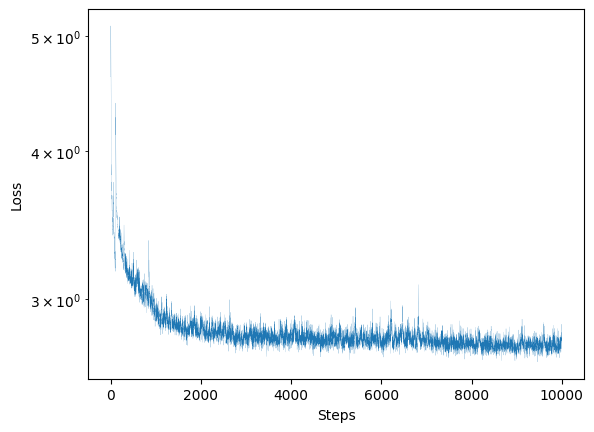

In [11]:
plt.plot(training_losses, linewidth=0.1)
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

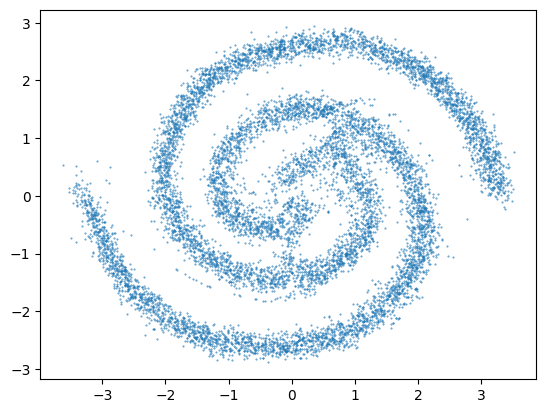

In [12]:
model.eval()
with torch.inference_mode():
    x_samples = model.sample(10_000).cpu()

plt.scatter(x_samples[:, 0], 
            x_samples[:, 1],
            s=0.2,
            alpha=0.8)
plt.show()

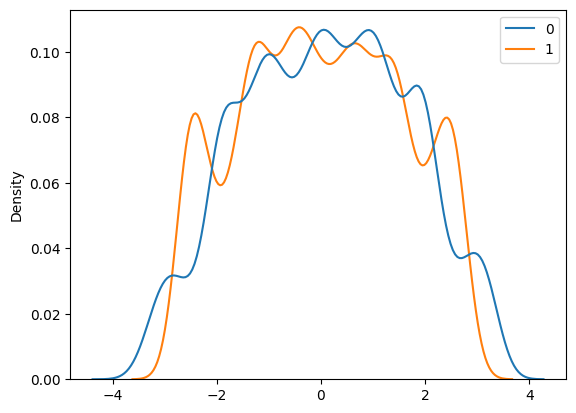

In [13]:
sns.kdeplot(x_samples)
plt.show()

### Test CheckerBoard

In [8]:
def checkerboard_generate_sample(n_samples):
    x1 = np.random.rand(n_samples) * 4 - 2
    x2_ = np.random.rand(n_samples) - np.random.randint(0, 2, n_samples) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    return np.concatenate([x1[:, None], x2[:, None]], 1) * 2

In [9]:
num_flows = 4
steps = 10_000
batch_size = 5000

masks = torch.tensor([[0, 1], [1, 0]] * num_flows).float()
model = RealNVP(masks).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

In [10]:
model.train()
training_losses = []
for s in range(steps):
    cb = checkerboard_generate_sample(n_samples=batch_size)
    cb = torch.from_numpy(cb).float().to(device=device)

    optimizer.zero_grad()
    # Compute negative log-likelihood (NLL)
    log_prob = model.log_prob(cb)
    loss = -log_prob.mean()  # Maximize log-likelihood (equivalent to minimizing -log_prob)
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    if (s + 1) % 1000 == 0:
        print(f"[step {s + 1}/{steps}] loss: {loss.item():.3e}")

[step 1000/10000] loss: 3.633e+00
[step 2000/10000] loss: 3.608e+00
[step 3000/10000] loss: 3.595e+00
[step 4000/10000] loss: 3.607e+00
[step 5000/10000] loss: 3.559e+00
[step 6000/10000] loss: 3.560e+00
[step 7000/10000] loss: 3.581e+00
[step 8000/10000] loss: 3.574e+00
[step 9000/10000] loss: 3.552e+00
[step 10000/10000] loss: 3.547e+00


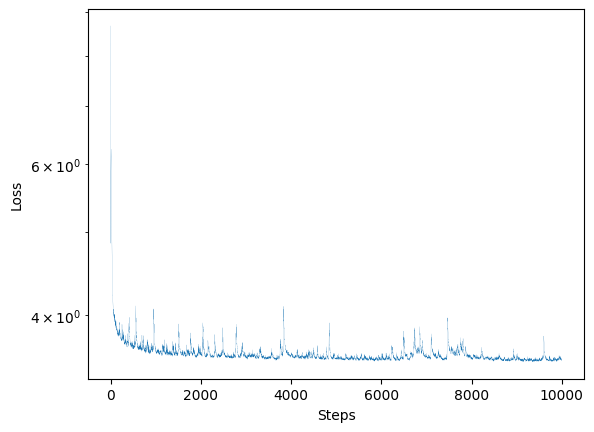

In [12]:
plt.plot(training_losses, linewidth=0.1)
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

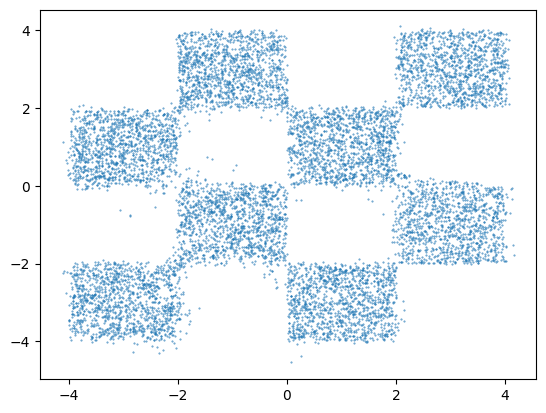

In [13]:
model.eval()
with torch.inference_mode():
    x_samples = model.sample(10_000).cpu()

plt.scatter(x_samples[:, 0], 
            x_samples[:, 1],
            s=0.2,
            alpha=0.8)
plt.show()